<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Overfitting%20Model%20for%20Hybrid%20RF-LSTM%20for%204%20class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for 4 class classifications based on WSNBFSF dataset ver.2**

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Load dataset
dataset = pd.read_csv("dataset.csv")
dataset.isnull().sum()

Event             0
Time              0
S_Node            0
Node_id           0
Rest_Energy       0
Trace_Level       0
Mac_Type_Pckt     0
Source_IP_Port    0
Des_IP_Port       0
Packet_Size       0
TTL               0
Hop_Count         0
Broadcast_ID      0
Dest_Node_Num     0
Dest_Seq_Num      0
Src_Node_ID       0
Src_Seq_Num       0
Class             0
dtype: int64

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312106 entries, 0 to 312105
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           312106 non-null  int64  
 1   Time            312106 non-null  float64
 2   S_Node          312106 non-null  int64  
 3   Node_id         312106 non-null  int64  
 4   Rest_Energy     312106 non-null  float64
 5   Trace_Level     312106 non-null  int64  
 6   Mac_Type_Pckt   312106 non-null  int64  
 7   Source_IP_Port  312106 non-null  float64
 8   Des_IP_Port     312106 non-null  float64
 9   Packet_Size     312106 non-null  int64  
 10  TTL             312106 non-null  int64  
 11  Hop_Count       312106 non-null  int64  
 12  Broadcast_ID    312106 non-null  int64  
 13  Dest_Node_Num   312106 non-null  int64  
 14  Dest_Seq_Num    312106 non-null  int64  
 15  Src_Node_ID     312106 non-null  int64  
 16  Src_Seq_Num     312106 non-null  int64  
 17  Class     

**Data Preprocessing**

In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=4)  # update to 4 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(312106, 17)
(312106, 4)


In [8]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Hybrid RF-LSTM for 4 class Ver.2**

In [11]:
# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, np.argmax(y_train, axis=1))

# Extract features from RF model
train_rf_features = rf_model.predict_proba(X_train)
test_rf_features = rf_model.predict_proba(X_test)

In [15]:
# Reshape train_rf_features to 3D array
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], train_rf_features.shape[1], 1))

# Train LSTM model with RF features as input
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(train_rf_features.shape[1], train_rf_features.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.fit(train_rf_features, y_train, epochs=15, batch_size=64)

Epoch 1/15
13143/13143 [==============================] - 376s 28ms/step - loss: 0.0077 - accuracy: 0.9973
Epoch 2/15
13143/13143 [==============================] - 328s 25ms/step - loss: 1.3203e-04 - accuracy: 1.0000
Epoch 3/15
13143/13143 [==============================] - 331s 25ms/step - loss: 7.1810e-05 - accuracy: 1.0000
Epoch 4/15
13143/13143 [==============================] - 324s 25ms/step - loss: 4.2481e-05 - accuracy: 1.0000
Epoch 5/15
13143/13143 [==============================] - 319s 24ms/step - loss: 6.6931e-05 - accuracy: 1.0000
Epoch 6/15
13143/13143 [==============================] - 320s 24ms/step - loss: 7.7252e-08 - accuracy: 1.0000
Epoch 7/15
13143/13143 [==============================] - 320s 24ms/step - loss: 1.0165e-08 - accuracy: 1.0000
Epoch 8/15
13143/13143 [==============================] - 319s 24ms/step - loss: 4.7823e-09 - accuracy: 1.0000
Epoch 9/15
13143/13143 [==============================] - 320s 24ms/step - loss: 2.7889e-09 - accuracy: 1.0000
Epoch

In [20]:
# Evaluate LSTM model on test set
test_rf_features_lstm = rf_model.predict_proba(X_test)
test_rf_features_lstm = np.reshape(test_rf_features_lstm, (test_rf_features_lstm.shape[0], 4, 1))  # Modify shape to (None, 4, 1)
test_lstm_features = lstm_model.predict(test_rf_features_lstm)

# Evaluate hybrid model on test set
test_rf_features_lstm = np.argmax(test_lstm_features, axis=1)

print(confusion_matrix(np.argmax(y_test, axis=1), test_rf_features_lstm))
print(classification_report(np.argmax(y_test, axis=1), test_rf_features_lstm))

6572/6572 [==============================] - 40s 6ms/step
[[52494     3     0     3]
 [   16 52529     0     9]
 [    3     0 52533     9]
 [    0    16    15 52651]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52500
           1       1.00      1.00      1.00     52554
           2       1.00      1.00      1.00     52545
           3       1.00      1.00      1.00     52682

    accuracy                           1.00    210281
   macro avg       1.00      1.00      1.00    210281
weighted avg       1.00      1.00      1.00    210281



In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='gist_earth')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


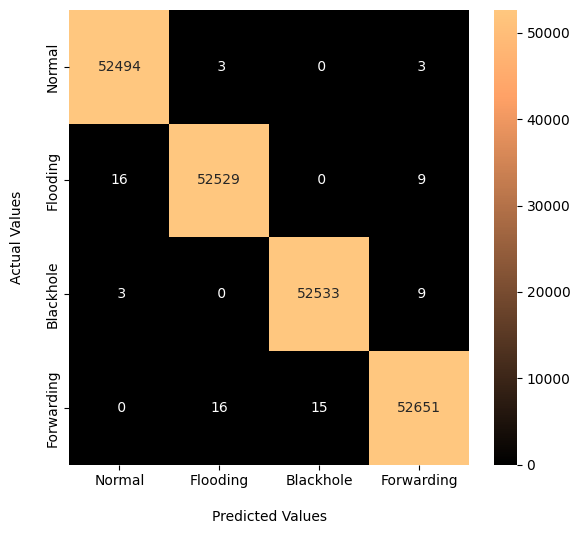

In [22]:
print("Confusion Matrix of Hybrid RF-LSTM Model") 
conf_mat(np.argmax(y_test, axis=1), test_rf_features_lstm)

In [23]:
report = classification_report(np.argmax(y_test, axis=1), test_rf_features_lstm, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid RF-LSTM Model:", detection_rates)

Detection rates of Hybrid RF-LSTM Model: {0: 0.9998857142857143, 1: 0.9995242988164554, 2: 0.9997716243220097, 3: 0.9994115637219544}


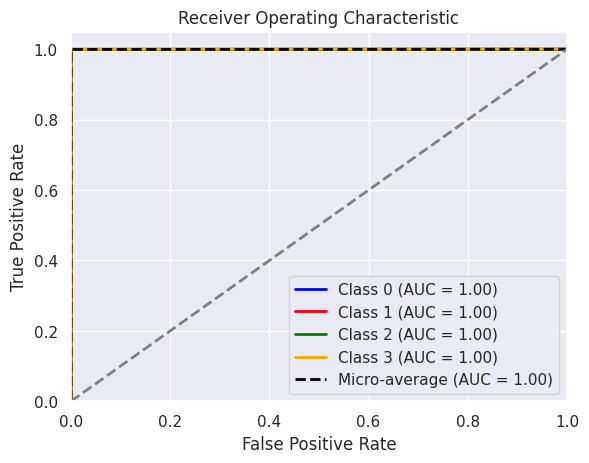

[[52494     3     0     3]
 [   16 52529     0     9]
 [    3     0 52533     9]
 [    0    16    15 52651]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52500
           1       1.00      1.00      1.00     52554
           2       1.00      1.00      1.00     52545
           3       1.00      1.00      1.00     52682

    accuracy                           1.00    210281
   macro avg       1.00      1.00      1.00    210281
weighted avg       1.00      1.00      1.00    210281



In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import np_utils

# Convert y_test and test_rf_features to one-hot encoded format
y_test_onehot = np_utils.to_categorical(np.argmax(y_test, axis=1))
test_rf_features_onehot = np_utils.to_categorical(test_rf_features_lstm)  # Convert to one-hot encoded format

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_features_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_features_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))

Epoch 1/15
13143/13143 [==============================] - 377s 29ms/step - loss: 1.0070e-08 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9997
Epoch 2/15
13143/13143 [==============================] - 353s 27ms/step - loss: 7.3777e-06 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9997
Epoch 3/15
13143/13143 [==============================] - 349s 27ms/step - loss: 1.4438e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9996
Epoch 4/15
13143/13143 [==============================] - 369s 28ms/step - loss: 7.7853e-09 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 0.9997
Epoch 5/15
13143/13143 [==============================] - 345s 26ms/step - loss: 2.8306e-05 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9996
Epoch 6/15
13143/13143 [==============================] - 349s 27ms/step - loss: 2.1208e-05 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9996
Epoch 7/15
13143/13143 [==============================] - 367s 28ms/step - loss: 6

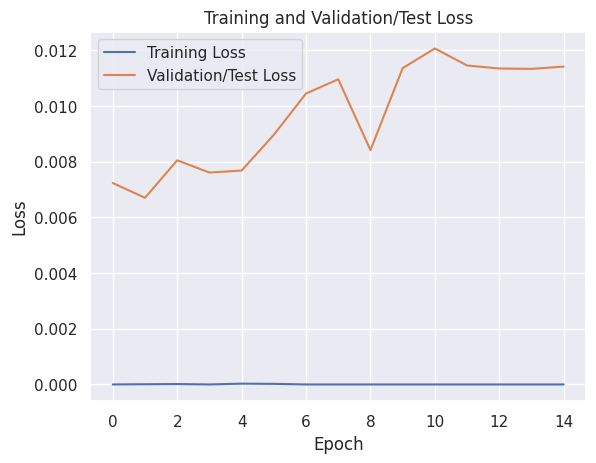

In [28]:
import matplotlib.pyplot as plt
history = lstm_model.fit(train_rf_features, y_train, epochs=15, batch_size=64, validation_data=(test_rf_features, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()